**MODELO PARA RECONSTRUCCIÓN DE TRAZAS**

Creado por PAUL GOYES

Email: ypgoype@correo.uis.edu.co


Requerimientos:



1.   Los datos deben estar normalizados entre -1 y 1.




In [1]:
#!pip install sporco
from sporco import array,plot,util
from sporco import metric

In [2]:
import tensorflow as tf
import keras
#visualización de imagenes
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import scipy
import numpy as np

In [3]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)
R2 = keras.models.load_model('Unet_reconblcks1000_variation2.h5')

In [4]:
#R2.compile()
R2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 14, 14, 64)   1600        ['input_6[0][0]']                
                                                                                                  
 batch_normalization_35 (BatchN  (None, 14, 14, 64)  256         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_16 (Conv2D)             (None, 7, 7, 128)    204800      ['batch_normalization_35[0]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
!git clone https://github.com/PAULGOYES/pylops_seismic_cs.git
#spii15s.npy
from skimage.transform import rescale, resize, downscale_local_mean


def rescalSeismic(data_input,size=(64,64)):
  if len(data_input.shape)==3: 
    new = np.zeros((size[0],size[1],data_input.shape[-1]))
    for i in range(new.shape[-1]):
        new[:,:,i] = resize(data_input[:,:,i], size,
                            anti_aliasing=True)
    return new
  
  elif len(data_input.shape)==2:
    new = resize(data_input, size,
                          anti_aliasing=True)
    return new




Cloning into 'pylops_seismic_cs'...


the shape is:  (128, 128, 15)


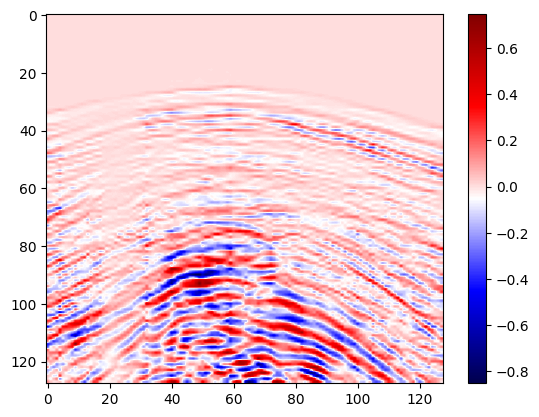

In [6]:
#ASEGURESE QUE LOS DATOS SE ENCUENTREN ENTRE -1 y 1 en el rango de amplitudes


#Data = rescalSeismic(np.load('pylops_seismic_cs/cube4.npy')[:600,:,:],size=(128,128))
#Data = rescalSeismic(np.load('pylops_seismic_cs/syn3D_cross-spread2.npy')[:,:,:],size=(128,128))
#Data = rescalSeismic(np.load('pylops_seismic_cs/coil_synt_cspread.npy')[:,:,:],size=(128,128))
Data = rescalSeismic(np.load('pylops_seismic_cs/spii15s.npy')[:,:,:],size=(128,128)) #
#Data = rescalSeismic(np.loadtxt('pylops_seismic_cs/dataMASW.ascii').T,size=(128,128))



#si los datos originales están entre 0 y 1, se puede aplicar la siguiente operación
#Data *=2
#Data -=1

shot=2

plt.figure()
plt.imshow(Data[:,:,shot],aspect='auto',cmap='seismic')
plt.colorbar()


print('the shape is: ', Data.shape)

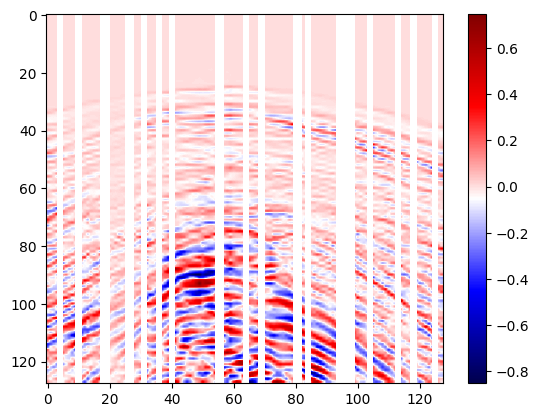

In [7]:
singleffid = Data[:,:,shot].copy()
indxx = np.random.RandomState(seed=42).permutation(singleffid.shape[1])

singleffid[:,indxx[:20]]=0

view = singleffid.copy()
view[:,indxx[:23]]=None
plt.figure()
plt.imshow(view,aspect='auto',cmap='seismic')
plt.colorbar()

    DIVIDIR EL DISPARO SÍSMICO EN BLOQUES

In [8]:
#blksz : Tamaño del bloque, es fijo!
#stpsz : strides, variable (recomendado máximo 5, ideal 1)

blksz= (28,28)
stpsz= (1,1)

blcks = array.extract_blocks(singleffid, blksz, stpsz)

C:\Users\USUARIO\.conda\envs\reds\lib\site-packages\sporco\plot.py:697: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:title={'center':'D0'}>)

<Figure size 1000x1000 with 0 Axes>

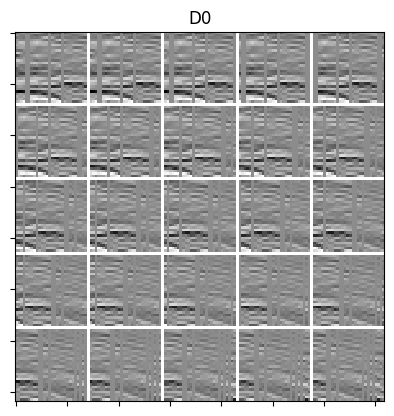

In [9]:
plt.figure(figsize=(10,10))
plot.imview(util.tiledict(blcks[:,:,25*200
                                       :25*201]), title='D0')

In [10]:
# bloques en arreglo para ingresar a la red
subblcks = blcks.transpose(2,0,1)[:,:,:,np.newaxis]

In [11]:
#blques salida de la red - reconstruidos
recov_blcks = R2.predict(subblcks)

319/319 [==============================] - 13s 39ms/step


    VISUALIZAR LA RECONSTRUCCIÓN POR BLOQUES

(<matplotlib.image.AxesImage at 0x206c80208e0>,
 <matplotlib.colorbar.Colorbar at 0x206c80781c0>)

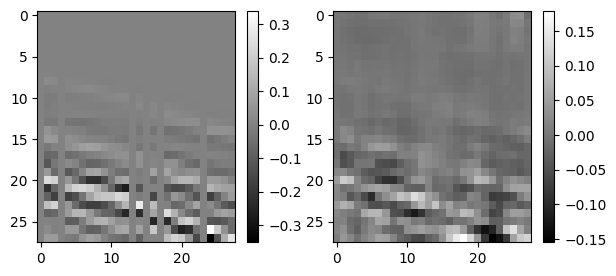

In [12]:
kk = 2000

plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(subblcks[kk,:,:,0],aspect='auto',cmap='gray'), plt.colorbar()
#plt.colorbar()
#plt.subplot(223)
#plt.imshow(tffkdomain(tf.constant(subblcks[kk:kk+1,:,:,0:1]))[0,:,:],cmap='jet'), plt.colorbar()
plt.subplot(122)
plt.imshow(recov_blcks[kk,:,:,0],aspect='auto',cmap='gray'), plt.colorbar()
#plt.subplot(224)
#plt.imshow(tffkdomain(tf.constant(recov_blcks[kk:kk+1,:,:,0:1]))[0,:,:],cmap='jet'), plt.colorbar()

    RECONSTRUIR LA IMAGEN A PARTIR DE LOS BLOQUES

In [13]:
Urec  = recov_blcks.squeeze().transpose(1,2,0)
Urec = Urec.reshape(np.product(blksz), -1)

In [14]:
# Dado que los bloques tienen overlapping, es necesario aplicar una operación para obtener un único valor en cierta posición
# se puede seleccionar la media o la mediana

imgd_mean = array.average_blocks(Urec.reshape(blksz + (-1,))
                                 , singleffid.shape, stpsz)

imgd_median = array.combine_blocks(Urec.reshape(blksz + (-1,))
                                 , singleffid.shape, stpsz, np.median)

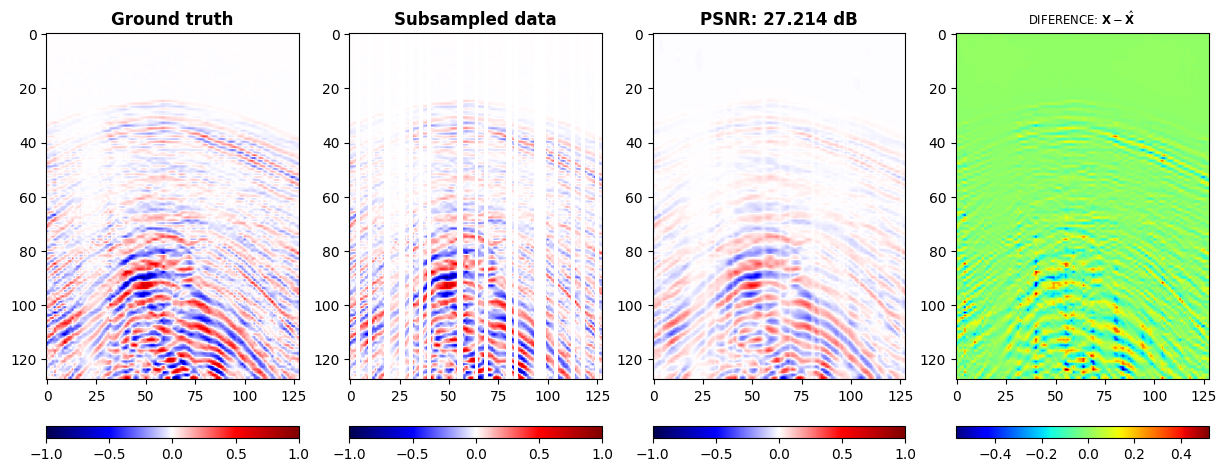

In [15]:
plt.figure(figsize=(15,6))

plt.subplot(141)
plt.imshow(Data[:,:,shot],aspect='auto',cmap='seismic')
plt.title('Ground truth',fontweight="bold")
plt.clim([-1,1]),plt.colorbar(orientation='horizontal',pad=0.1)
plt.subplot(142)
plt.imshow(view,aspect='auto',cmap='seismic')
plt.title('Subsampled data',fontweight="bold")
plt.clim([-1,1]),plt.colorbar(orientation='horizontal',pad=0.1)
plt.subplot(143)
plt.imshow(imgd_median,aspect='auto',cmap='seismic')
plt.clim([-1,1]), plt.colorbar(orientation='horizontal',pad=0.1)
plt.title("PSNR: %.3f dB" % (metric.psnr(Data[:,indxx,shot],imgd_median[:,indxx])),fontweight="bold")
plt.subplot(144)
plt.imshow(Data[:,:,shot]-imgd_median,aspect='auto',cmap='jet')
plt.title(r"DIFERENCE: $\mathbf{X}-\hat{\mathbf{X}}$",fontsize='small')
plt.colorbar(orientation='horizontal',pad=0.1)

    VISUALIZAR UNA TRAZA SÍSMICA RECONSTRUIDA

Text(0.5, 1.0, 'Trace index:92 PSNR: 23.366 dB')

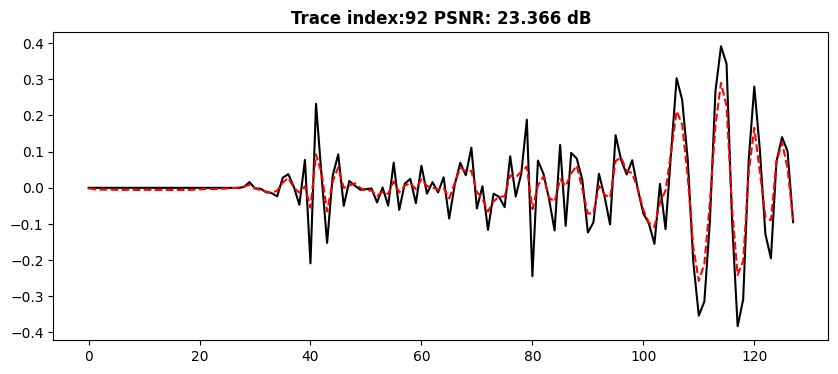

In [16]:
#reemplazar el valor de "k" por el indice de la traza sísmica a reconstruir
k = -3

plt.figure(figsize=(10,4))
plt.plot(Data[:,indxx[k],shot],'k')
#plt.plot(imgd_mean[:,indxx[k]],'--b')
plt.plot(imgd_median[:,indxx[k]],'--r')
plt.title("Trace index:%.0f PSNR: %.3f dB" % (indxx[k],metric.psnr(Data[:,indxx[k],shot],imgd_median[:,indxx[k]])),fontweight="bold")
